In [1]:

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("csgo_round_snapshots.csv")

In [2]:
df

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,de_train,True,200.0,242.0,195.0,359.0,100.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122406,174.93,11.0,15.0,de_train,False,500.0,500.0,95.0,175.0,11500.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122407,114.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,4.0,3.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0,T
122408,94.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,5.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,T


In [ ]:
print(df['time_left'])

problematic_indices = []
filt = []

for i in range(1,df.shape[0]):
    if (df.loc[i,'ct_score'] != df.loc[i-1, 'ct_score']) and (df.loc[i,'t_score'] != df.loc[i-1, 't_score']) and (df.loc[i-1,'ct_score'] != 15.0) and (df.loc[i-1,'t_score'] != 15.0):
        problematic_indices.append(i)
        filt.append(i-1)
        filt.append(i)

print(len(problematic_indices))

df.loc[filt]

0         175.00
1         156.03
2          96.03
3          76.03
4         174.97
           ...  
122405     15.41
122406    174.93
122407    114.93
122408     94.93
122409     74.93
Name: time_left, Length: 122410, dtype: float64
678


,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
79,74.96,10.0,4.0,de_dust2,False,109.0,200.0,200.0,200.0,20050.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,CT
80,175.00,4.0,11.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
186,35.15,8.0,6.0,de_mirage,True,200.0,262.0,200.0,295.0,700.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,T
187,169.95,7.0,8.0,de_mirage,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
380,32.98,4.0,10.0,de_dust2,True,139.0,170.0,200.0,199.0,1250.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121845,175.00,0.0,0.0,de_nuke,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
121938,19.80,11.0,3.0,de_nuke,True,100.0,184.0,100.0,196.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,T
121939,175.00,4.0,11.0,de_nuke,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122324,54.94,8.0,6.0,de_train,False,238.0,370.0,298.0,366.0,1600.0,...,3.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,T


In [ ]:
df.keys()

Index(['time_left', 'ct_score', 't_score', 'map', 'bomb_planted', 'ct_health',
       't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets',
       't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive',
       'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug',
       'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
       'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite',
       't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas',
       'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar',
       't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock',
       'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s', 't_weapon_m4a1s',
       'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mac10', 't_weapon_mac10',
       'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd',
       'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',
       'ct_weapon_negev', 't_weapon_negev',

de_inferno     23811
de_dust2       22144
de_nuke        19025
de_mirage      18576
de_overpass    14081
de_train       13491
de_vertigo     11137
de_cache         145
Name: map, dtype: int64


Text(0, 0.5, 'Count')

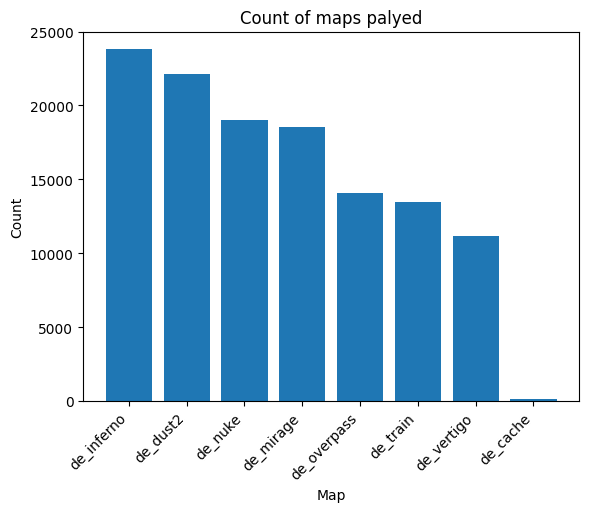

In [ ]:

counts = df['map'].value_counts()
print(counts)
total = counts.sum()
percentages = counts / total * 100

plt.bar(counts.index, counts.values)

plt.xticks(rotation=45, ha='right')
plt.title('Count of maps played')
plt.xlabel('Map')
plt.ylabel('Count')

In [ ]:
df.groupby('map').mean()

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
map,,,,,,,,,,,,,,,,,,,,,
de_cache,87.943517,7.241379,5.600000,0.075862,407.420690,382.668966,346.979310,288.234483,13825.862069,6438.620690,...,2.427586,1.441379,1.524138,1.089655,1.496552,0.041379,0.034483,0.944828,0.020690,0.006897
de_dust2,98.222937,6.805997,6.690345,0.120574,410.449467,405.316474,307.531115,301.748058,9052.266980,11978.497561,...,1.734149,1.794978,1.295114,1.732072,0.928378,0.015128,0.059294,1.506277,0.031882,0.032334
de_inferno,94.233469,6.601151,6.866616,0.129436,411.426274,400.141237,318.295494,302.073537,9771.473269,11640.561085,...,1.878922,1.795137,1.632985,1.811012,1.064214,0.021083,0.027214,1.215027,0.021797,0.027046
de_mirage,99.459346,6.766419,6.948697,0.112672,413.129791,405.970823,311.000431,298.091677,9684.278101,10819.062231,...,1.749462,1.889481,1.583925,1.363910,0.977175,0.021425,0.054156,1.401863,0.030523,0.024494
de_nuke,100.944179,6.725204,6.778239,0.097346,416.116478,400.878213,321.352326,291.512063,10915.590013,10731.306176,...,2.152168,1.958371,1.516794,1.418344,1.006833,0.026124,0.064021,1.319001,0.028489,0.020552
de_overpass,96.788056,6.540089,6.602940,0.095093,412.287409,405.968894,313.337334,304.271288,9418.329664,11816.678503,...,1.783680,1.874086,1.586393,1.766991,0.921241,0.010866,0.036006,1.326468,0.024572,0.026206
de_train,99.807817,6.754874,6.732414,0.104811,414.307316,400.797198,317.299385,285.990067,10495.315395,10031.932399,...,1.875843,1.790898,1.601660,1.522274,1.084797,0.025054,0.052109,1.244682,0.030391,0.016678
de_vertigo,96.376471,6.776960,6.796354,0.109814,405.465655,399.216935,308.095627,304.402622,9102.240280,11294.513783,...,1.749753,1.961210,1.670288,1.778396,1.043549,0.017689,0.042830,1.479932,0.026668,0.031517


In [ ]:
df.groupby('map')['map'].count()

map
de_cache         145
de_dust2       22144
de_inferno     23811
de_mirage      18576
de_nuke        19025
de_overpass    14081
de_train       13491
de_vertigo     11137
Name: map, dtype: int64

In [ ]:
df.groupby('map')['map'].count().values

array([  145, 22144, 23811, 18576, 19025, 14081, 13491, 11137])

In [ ]:
df.groupby('map')['map'].count().values.reshape(-1, 1)

array([[  145],
       [22144],
       [23811],
       [18576],
       [19025],
       [14081],
       [13491],
       [11137]])

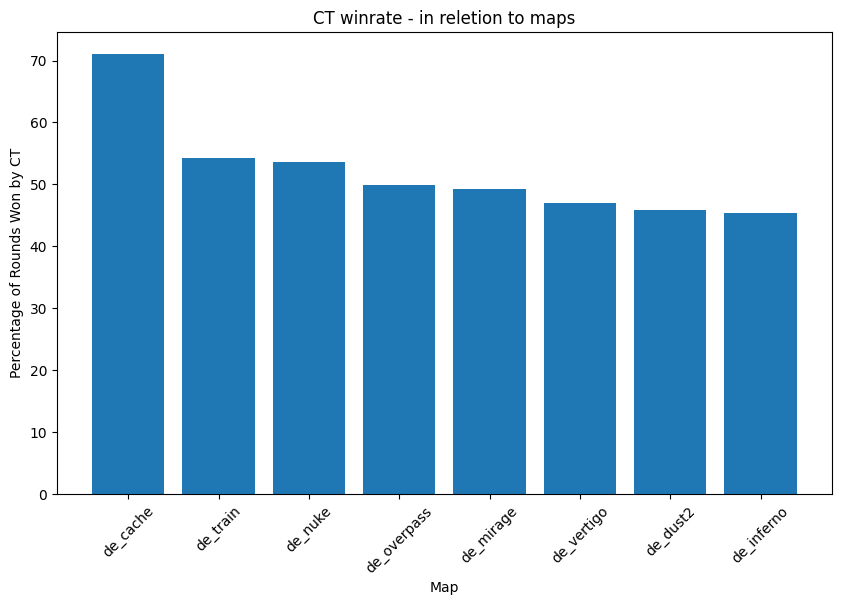

In [ ]:
map_win_pct = df.groupby(['map', 'round_winner'])['round_winner'].count().unstack() / df.groupby('map')['map'].count().values.reshape(-1, 1)
ct_win_pct = map_win_pct['CT']*100

ct_win_pct = ct_win_pct.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(ct_win_pct.index, ct_win_pct)
plt.xticks(rotation=45)

plt.xlabel('Map')
plt.ylabel('Percentage of Rounds Won by CT')
plt.title('CT winrate - in reletion to maps')
plt.show()